## Import modules

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import manifold
from sklearn.utils import shuffle

## Load datasets

In [ ]:
with h5py.File('../../pcam/training_split.h5', 'r') as f:
  train_data = f['x'][:]

with h5py.File('../../pcam/validation_split.h5', 'r') as f:
  val_data = f['x'][:]

with h5py.File('../../pcam/test_split.h5', 'r') as f:
  test_data = f['x'][:]

In [ ]:
with h5py.File('../../Labels/Labels/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
    train_labels = f['y'][:].reshape(-1,)

with h5py.File('../../Labels/Labels/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
    val_labels = f['y'][:].reshape(-1,)

with h5py.File('../../Labels/Labels/camelyonpatch_level_2_split_test_y.h5', 'r') as f:
    test_labels = f['y'][:].reshape(-1,)

In [4]:
n_samples = 1000

## Distribution of labels

In [5]:
print('Total number of positive examples', (train_labels == 1).sum())
print('Total number of negative examples', (train_labels == 0).sum())

Total number of positive examples 131072
Total number of negative examples 131072


In [6]:
train_data, train_labels = shuffle(train_data, train_labels, n_samples=n_samples, random_state=0)

We observe that there is no dataset imbalance.

## T-SNE plots for the dataset (96 x 96)

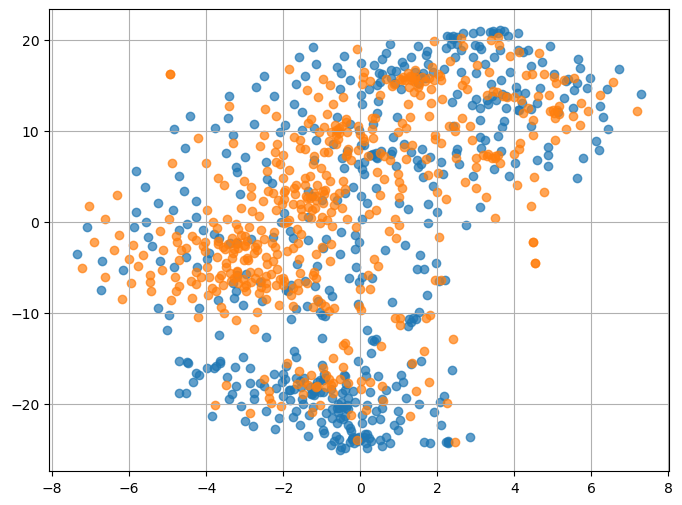

In [7]:
tsne = manifold.TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)

# sample a few data points
sampled_data, sampled_labels = shuffle(train_data.reshape(train_data.shape[0], -1), train_labels, n_samples=n_samples, random_state=42)

train_data_transformed = tsne.fit_transform(sampled_data)

plt.figure(figsize=(8, 6))
for label in np.unique(sampled_labels):
    plt.scatter(
        train_data_transformed[sampled_labels == label, 0],  # x-coordinates
        train_data_transformed[sampled_labels == label, 1],  # y-coordinates
        label=f"Label {label}",
        alpha=0.7
    )

plt.grid()

## T-SNE plots for the dataset (32 x 32)

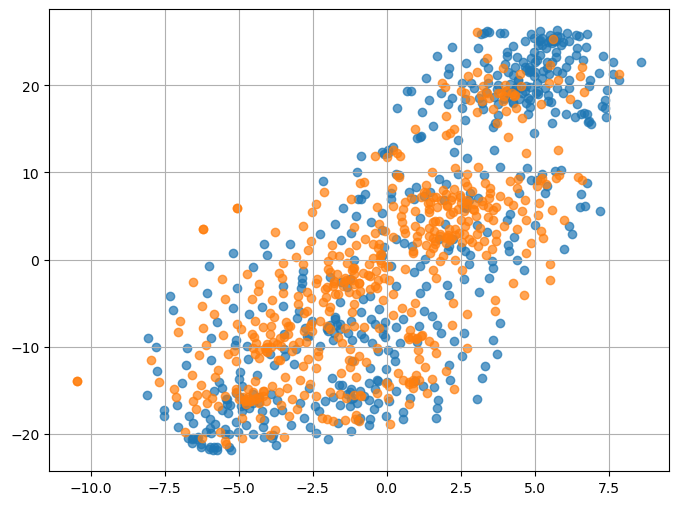

In [8]:
tsne = manifold.TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)

train_data_centered = train_data[:, 48 - 16: 48 + 16, 48 - 16: 48 + 16, :]

# sample a few data points
sampled_data, sampled_labels = shuffle(train_data.reshape(train_data_centered.shape[0], -1), train_labels, n_samples=n_samples, random_state=42)

train_data_transformed = tsne.fit_transform(sampled_data)

plt.figure(figsize=(8, 6))
for label in np.unique(sampled_labels):
    plt.scatter(
        train_data_transformed[sampled_labels == label, 0],  # x-coordinates
        train_data_transformed[sampled_labels == label, 1],  # y-coordinates
        label=f"Label {label}",
        alpha=0.7
    )

plt.grid()

Conclusion: Not very informative

## Check for duplicates

In [9]:
import hashlib

def check_for_duplicates(arr):
    hash_table = {}
    flag = 0
    for i, image in enumerate(arr):
        # Flatten the image for hashing
        flattened_image = image.flatten()
        # Choose a suitable hash function
        hash_value = hashlib.sha256(flattened_image).hexdigest()
        if hash_value in hash_table:
            # Potential duplicate, perform detailed comparison
            if np.array_equal(hash_table[hash_value], image):
                print(f"Duplicate found at indices: {hash_table[hash_value]}, {i}")
                flag = 1
        else:
            hash_table[hash_value] = i

    if not flag:
        print("No duplicates found!")

check_for_duplicates(train_data)

No duplicates found!


### Plot HOG image to see for details

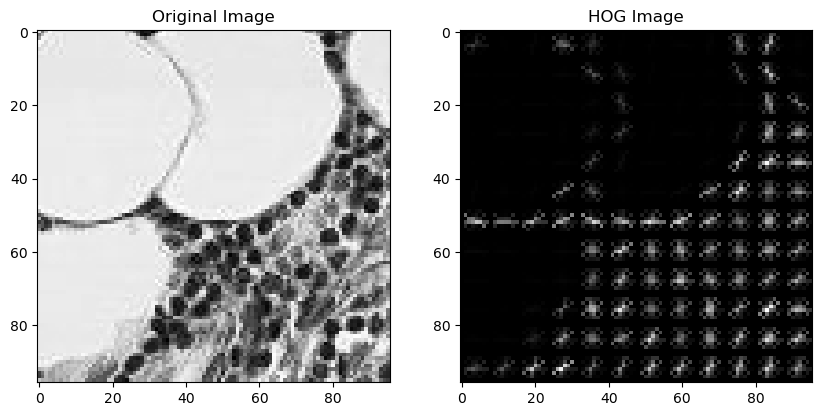

HOG feature vector length: 4356


In [10]:
from skimage.feature import hog
from skimage import color, io
import matplotlib.pyplot as plt

# Load image and convert to grayscale
# image = io.imread('example.jpg')  # Replace with your image path
image = train_data[0]
gray_image = color.rgb2gray(image)

# Compute HOG features
hog_features, hog_image = hog(
    gray_image,
    orientations=9,       # Number of bins
    pixels_per_cell=(8, 8),   # Size of cell (in pixels)
    cells_per_block=(2, 2),   # Number of cells per block
    block_norm='L2-Hys',  # Normalization method
    visualize=True        # Return the HOG image for visualization
)

# Display the HOG image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("HOG Image")
plt.imshow(hog_image, cmap='gray')
plt.show()

print("HOG feature vector length:", len(hog_features))


### Histogram intensity distribution for positive samples 

In [11]:
from skimage import color

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

positive_samples = train_data[train_labels == 1]
negative_samples = train_data[train_labels == 0]

pos_intensities = dict()

def return_counts(image):
    global pos_intensities
    grayscale = (0.299 * image[:, :, 0] + 
             0.587 * image[:, :, 1] + 
             0.114 * image[:, :, 2]).astype(np.uint8)
    unique, counts = np.unique(grayscale, return_counts=True)
    pos_intensities = {unique[i]: pos_intensities.get(unique[i], 0) + counts[i] for i in range(len(unique))}

func = lambda x: return_counts(x)
func(positive_samples)


neg_intensities = dict()

def return_counts(image):
    global neg_intensities
    grayscale = (0.299 * image[:, :, 0] + 
             0.587 * image[:, :, 1] + 
             0.114 * image[:, :, 2]).astype(np.uint8)
    unique, counts = np.unique(grayscale, return_counts=True)
    neg_intensities = {unique[i]: neg_intensities.get(unique[i], 0) + counts[i] for i in range(len(unique))}

func = lambda x: return_counts(x)
func(negative_samples)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


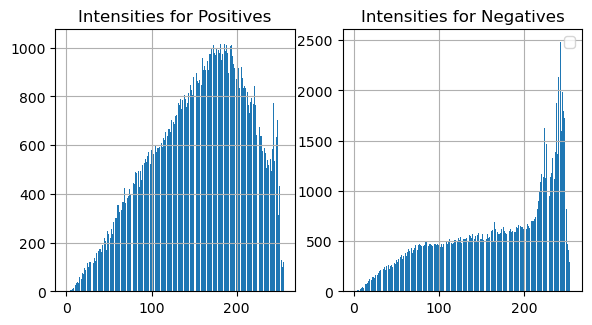

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6.8, 3.4))

ax[0].bar(pos_intensities.keys(), pos_intensities.values())
ax[0].set_title('Intensities for Positives'); ax[0].grid()
ax[1].bar(neg_intensities.keys(), neg_intensities.values())
ax[1].set_title('Intensities for Negatives'); ax[1].grid()
plt.legend()

### Hypothesis testing for malign and benign images

In [ ]:
import numpy as np
from skimage.color import rgb2gray
from skimage.measure import label
from scipy.stats import ttest_ind

# Step 1: Preprocessing - Convert to grayscale and threshold
def preprocess_and_binarize(images):
    """
    Convert RGB images to grayscale and binarize them using a threshold.
    """
    binary_images = []
    for img in images:
        # Convert to grayscale
        gray = rgb2gray(img)  # Normalized grayscale (0 to 1)
        # Thresholding: Choose a threshold to binarize
        binary = (gray > 0.5).astype(np.uint8)  # Threshold at 0.5
        binary_images.append(binary)
    return np.array(binary_images)

# Step 2: Calculate the Euler characteristic for a binary image
def euler_characteristic(binary_image):
    """
    Compute the Euler characteristic of a 2D binary image.
    """
    labeled_image, num_features = label(binary_image, return_num=True)
    # Count the holes (assume connected components are holes)
    hole_count = sum(label(binary_image == 0, connectivity=1)[1])
    return num_features - hole_count

# Step 3: Compute Euler characteristics for all images
def compute_euler_characteristics(images):
    """
    Compute Euler characteristics for all binary images in the dataset.
    """
    euler_values = []
    for img in images:
        euler = euler_characteristic(img)
        euler_values.append(euler)
    return np.array(euler_values)

# Simulated Input: Positive and Negative Samples

# Preprocess and Binarize
positive_binary = preprocess_and_binarize(positive_samples)
negative_binary = preprocess_and_binarize(negative_samples)

# Calculate Euler characteristics
positive_euler = compute_euler_characteristics(positive_binary)
negative_euler = compute_euler_characteristics(negative_binary)

# Step 4: Hypothesis Testing
t_stat, p_value = ttest_ind(positive_euler, negative_euler)

# Output results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in Euler characteristics between the groups.")
else:
    print("No significant difference in Euler characteristics between the groups.")


T-statistic: -1.143010957920304
P-value: 0.2533081578168284
No significant difference in Euler characteristics between the groups.


In [ ]:
from scipy.stats import ks_2samp

ks_stat, ks_p_value = ks_2samp(positive_euler, negative_euler)

# Output KS test results
print(f"KS Statistic: {ks_stat}")
print(f"P-value (KS test): {ks_p_value}")
if ks_p_value < 0.05:
    print("KS test indicates a significant difference in distributions.")
else:
    print("KS test indicates no significant difference in distributions.")

KS Statistic: 0.16640066560266242
P-value (KS test): 1.4874937857903757e-06
KS test indicates a significant difference in distributions.
